In [1]:
import torch

def compute_z(a, b, c):
    r1 = torch.sub(a, b)
    r2 = torch.mul(r1, 2)
    z = torch.add(r2, c)
    return z

In [2]:
a = torch.tensor([1.0, 2.0, 3.0])
b = torch.tensor([0.5, 1.5, 2.5])
c = torch.tensor([0.1, 0.2, 0.3])

result = compute_z(a, b, c)
print(result)

tensor([1.1000, 1.2000, 1.3000])


In [4]:
a = torch.tensor(3.14, requires_grad=True)
print(a)

w = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
print(w)

tensor(3.1400, requires_grad=True)
tensor([1., 2., 3.], requires_grad=True)


Glorot initialization

In [5]:
import torch.nn as nn

torch.manual_seed(1)
w = torch.empty(2, 3)
nn.init.xavier_normal_(w)
print(w)

tensor([[ 0.4183,  0.1688,  0.0390],
        [ 0.3930, -0.2858, -0.1051]])


In [6]:
class MyModule(nn.Module):
    def __init__(self):
        super(MyModule, self).__init__()
        self.w1 = nn.Parameter(torch.randn(2, 3), requires_grad=True)
        self.w2 = nn.Parameter(torch.randn(1, 2), requires_grad=True)
        
        nn.init.xavier_normal_(self.w1)
        nn.init.xavier_normal_(self.w2)

auto diff

In [7]:
w = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(0.5, requires_grad=True)
x = torch.tensor([1.4])
y = torch.tensor([2.1])
z = torch.add(torch.mul(w, x), b)
loss = (y-z).pow(2).sum()

In [8]:
loss.backward()
print('dL/dW:', w.grad)
print('dL/db:', b.grad)

dL/dW: tensor(-0.5600)
dL/db: tensor(-0.4000)


XOR classification problem

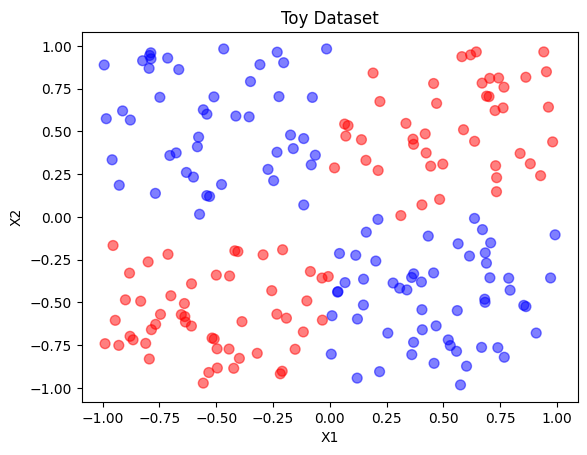

In [95]:
# Generate toy dataset
num_samples = 200
X = 2 * torch.rand(num_samples, 2) - 1  # Random distribution in range [-1, 1)
y = (X[:, 0] * X[:, 1] >= 0).float()  # Assign labels based on the condition

import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', alpha=0.5, s=50)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Toy Dataset')
plt.show()

In [102]:
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(2, 4),
    nn.ReLU(),
    nn.Linear(4, 4),
    nn.ReLU(),
    nn.Linear(4, 1),
    nn.Sigmoid()
)

print(model)

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
  (5): Sigmoid()
)


In [103]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [104]:
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a TensorDataset
dataset = TensorDataset(X_train, y_train)

# Create a DataLoader
data_loader = DataLoader(dataset, batch_size=10, shuffle=True)

In [105]:
torch.manual_seed(1)
def train_model(model, loss_fn, optimizer, data_loader, X_test, y_test, num_epochs=100):
    train_loss_history = [] * num_epochs
    train_acc_history = [] * num_epochs
    test_loss_history = [] * num_epochs
    test_acc_history = [] * num_epochs

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0

        for X_batch, y_batch in data_loader:
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch.unsqueeze(1))
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            # multiply a single loss value with the batch size
            train_loss += loss.item() * X_batch.size(0)
            
            correct_train += ((y_pred > 0.5).float() == y_batch.unsqueeze(1)).sum().item()
            
        # average the loss values across all training samples
        train_loss /= len(data_loader.dataset)
        train_acc = correct_train / len(data_loader.dataset)
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

        # model.eval()
        with torch.no_grad():
            y_test_pred = model(X_test)
            test_loss = loss_fn(y_test_pred, y_test.unsqueeze(1)).item()
            correct_test = ((y_test_pred > 0.5).float() == y_test.unsqueeze(1)).sum().item()
            test_acc = correct_test / len(y_test)
            test_loss_history.append(test_loss)
            test_acc_history.append(test_acc)
        
    return train_loss_history, train_acc_history, test_loss_history, test_acc_history


In [106]:
train_loss_history, train_acc_history, test_loss_history, test_acc_history = train_model(model, loss_fn, optimizer, data_loader, X_test, y_test, num_epochs=1000)

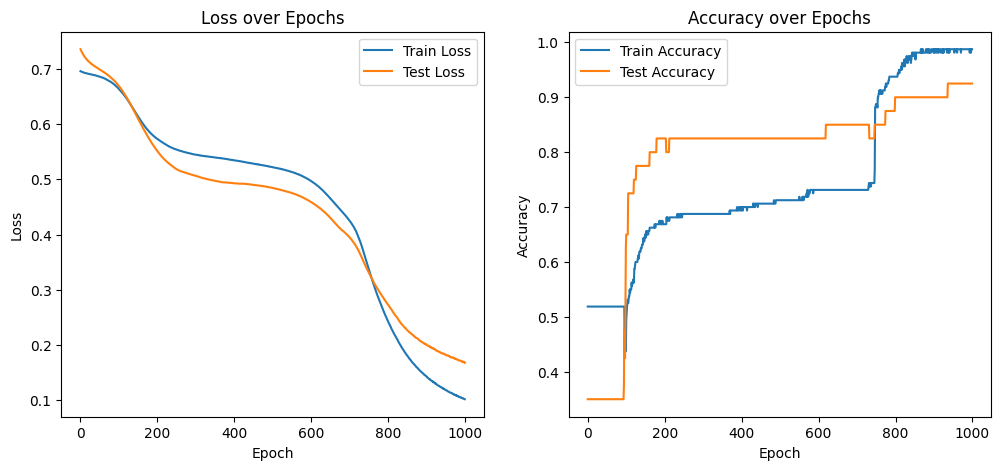

In [107]:
import matplotlib.pyplot as plt

# Plot training and testing loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(test_loss_history, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

# Plot training and testing accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(test_acc_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()

Visualize learned decision boundary.

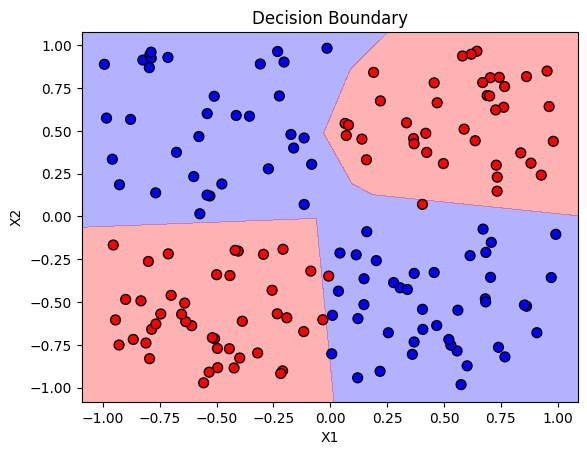

In [108]:
import numpy as np

import matplotlib.pyplot as plt

# Create a mesh grid
x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))

# Flatten the grid to pass through the model
grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
with torch.no_grad():
    Z = model(grid).reshape(xx.shape)

# Plot the decision boundary
plt.contourf(xx, yy, Z, levels=[0, 0.5, 1], alpha=0.3, colors=['blue', 'red'])

# Plot the training data
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='bwr', edgecolor='k', s=50)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Decision Boundary')
plt.show()

In [134]:
class XORModel(nn.Module):
    def __init__(self):
        super(XORModel, self).__init__()
        self.layers = nn.ModuleList([
            nn.Linear(2, 4, bias=True),
            nn.ReLU(),
            nn.Linear(4, 4, bias=True),
            nn.ReLU(),
            nn.Linear(4, 1, bias=True),
            nn.Sigmoid()
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def predict(self, X):
        x = torch.tensor(X, dtype=torch.float32)
        pred = self.forward(x)[:, 0]
        return (pred >= 0.5).float()

# Instantiate the model
model = XORModel()
print(model)

XORModel(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
    (5): Sigmoid()
  )
)


In [135]:
torch.manual_seed(1)
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)
train_loss_history, train_acc_history, test_loss_history, test_acc_history = train_model(model, loss_fn, optimizer, data_loader, X_test, y_test, num_epochs=500)

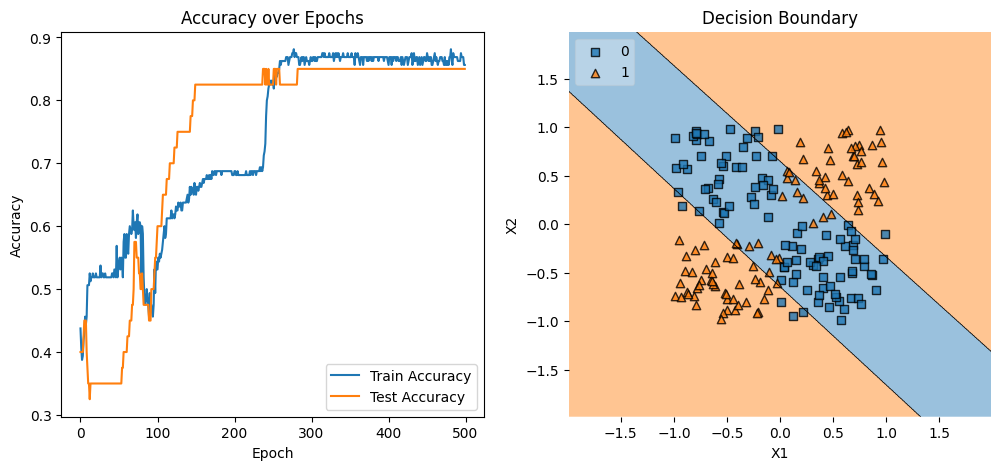

In [138]:
from mlxtend.plotting import plot_decision_regions

# Plot training and testing accuracy history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(test_acc_history, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

# Visualize decision boundary
plt.subplot(1, 2, 2)
plot_decision_regions(X.numpy(), y.numpy().astype(int), clf=model, legend=2)
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Decision Boundary')

plt.show()

Project 1 - predict car fuel efficiency

In [217]:
import seaborn as sns

# Load the MPG dataset
df = sns.load_dataset('mpg').drop('name', axis=1).dropna()

# Display the first few rows of the dataset
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
0,18.0,8,307.0,130.0,3504,12.0,70,usa
1,15.0,8,350.0,165.0,3693,11.5,70,usa
2,18.0,8,318.0,150.0,3436,11.0,70,usa
3,16.0,8,304.0,150.0,3433,12.0,70,usa
4,17.0,8,302.0,140.0,3449,10.5,70,usa


In [218]:
numeric_cols = [
    'cylinders',
    'displacement', 
    'horsepower', 
    'weight', 
    'acceleration'
]

In [219]:
from sklearn.model_selection import train_test_split

# Assuming df is your dataframe and 'mpg' is the target variable
X = df.drop(columns=['mpg'])
y = df['mpg']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (313, 7)
Testing set size: (79, 7)


In [220]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

X_train.head()

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
260,0.304862,0.284578,0.141429,0.754803,1.121759,78,usa
184,-0.873184,-0.535880,-0.329499,-0.493129,-0.228940,76,usa
174,0.304862,-0.236655,-0.198685,-0.002530,-0.371118,75,usa
64,1.482907,1.182255,1.187934,1.368052,-0.726565,72,usa
344,-0.873184,-1.057113,-1.062052,-1.323099,0.304231,81,usa


In [221]:
df['origin'].value_counts()

origin
usa       245
japan      79
europe     68
Name: count, dtype: int64

In [222]:
from sklearn.preprocessing import LabelEncoder

# Initialize the LabelEncoder
label_encoder = LabelEncoder()

# Fit and transform the 'origin' column
X['origin'] = label_encoder.fit_transform(X['origin'])
X_train['origin'] = label_encoder.transform(X_train['origin'])
X_test['origin'] = label_encoder.transform(X_test['origin'])

# Display the first few rows of the updated dataframe
X_train.head()

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
260,0.304862,0.284578,0.141429,0.754803,1.121759,78,2
184,-0.873184,-0.535880,-0.329499,-0.493129,-0.228940,76,2
174,0.304862,-0.236655,-0.198685,-0.002530,-0.371118,75,2
64,1.482907,1.182255,1.187934,1.368052,-0.726565,72,2
344,-0.873184,-1.057113,-1.062052,-1.323099,0.304231,81,2


In [223]:
import pandas as pd
bins = [0, 72, 75, 78, float('inf')]
labels = [0, 1, 2, 3]
X['model_year'] = pd.cut(X['model_year'], bins=bins, labels=labels, right=False)
X_train['model_year'] = pd.cut(X_train['model_year'], bins=bins, labels=labels, right=False)
X_test['model_year'] = pd.cut(X_test['model_year'], bins=bins, labels=labels, right=False)

# Display the first few rows of the updated dataframe
X_train.head()

,cylinders,displacement,horsepower,weight,acceleration,model_year,origin
260,0.304862,0.284578,0.141429,0.754803,1.121759,3,2
184,-0.873184,-0.535880,-0.329499,-0.493129,-0.228940,2,2
174,0.304862,-0.236655,-0.198685,-0.002530,-0.371118,2,2
64,1.482907,1.182255,1.187934,1.368052,-0.726565,1,2
344,-0.873184,-1.057113,-1.062052,-1.323099,0.304231,3,2


In [231]:
from torch.utils.data import DataLoader, TensorDataset

# Create a TensorDataset
dataset = TensorDataset(torch.tensor(X_train.values, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))

# Create a DataLoader
data_loader = DataLoader(dataset, batch_size=10, shuffle=True)

# Display the first batch
for X_batch, y_batch in data_loader:
    print(X_batch.shape, y_batch.shape)
    break

torch.Size([10, 7]) torch.Size([10])


In [232]:
X_train.shape

(313, 7)

In [236]:
import torch.nn as nn

model = nn.Sequential(
    nn.Linear(in_features=X_train.shape[1], out_features=8, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=8, out_features=4, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=4, out_features=1, bias=True)
)

print(model)

Sequential(
  (0): Linear(in_features=7, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
)


In [237]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
train_loss_history = []
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for X_batch, y_batch in data_loader:
        y_pred = model(X_batch).squeeze()
        
        loss = loss_fn(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        train_loss += loss.item() * X_batch.size(0)
        
    train_loss /= len(data_loader.dataset)
    train_loss_history.append(train_loss)

    if epoch % 10 == 0:
        print(f'Epoch {epoch} loss: {train_loss}')

Epoch 0 loss: 553.6237468292919
Epoch 10 loss: 10.720652171217214
Epoch 20 loss: 9.654493257260551
Epoch 30 loss: 9.632620413844197
Epoch 40 loss: 9.698138371062354


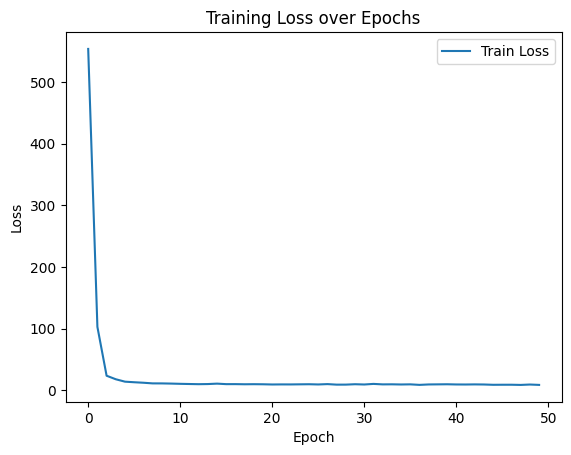

In [238]:
import matplotlib.pyplot as plt

plt.plot(train_loss_history, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()